## PID

### 連続時間
$$
\begin{aligned}
e(t) &= r(t) - y(t)\\
u(t) &= \underbrace{\vphantom{\int} K_pe(t)}_{比例P} + \underbrace{K_i\int_0^t e(\tau)d\tau}_{積分I} + \underbrace{\vphantom{\int} K_d\dot{e}(t)}_{微分D} \\
y(t) &= \int_0^t u(t) d\tau \\
\end{aligned}
$$

### 離散時間
$$
\begin{aligned}
e_{k} &= r_{k} - y_{k-1} \\
u_{k} &= K_p e_{k} + K_i \sum_0^n e_{n} + K_d \frac{ e_{k} - e_{k-1} }{dt} \\
y_{k} &= y_{k-1} + u_{k} dt \\
\end{aligned}
$$

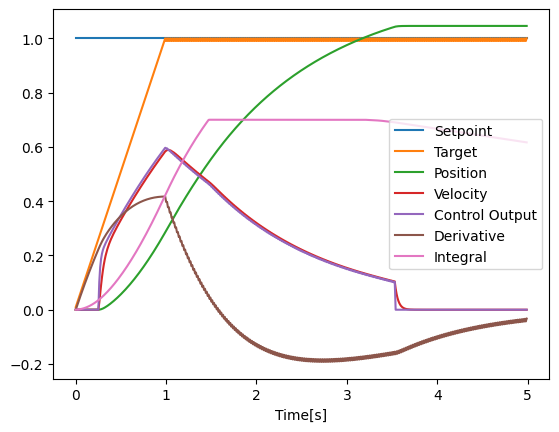

In [157]:
import matplotlib.pyplot as plt
import numpy as np

# モデル設定
dt = 10e-3 # 制御周期(100Hz = 10ms)
t = np.arange(0, 5, dt) # 時間(グラフの横軸) 0~10まで
setpoint = np.full_like(t, 1) # 目標値

# PIDゲイン
kp = 0.7
ki = 0.2
kd = 0.03
max_out = 0.7

def saturate(x):
  return max_out if x > max_out else -max_out if x < -max_out else x

# シミュレーション
position = np.zeros_like(t) # 状態出力
target = np.zeros_like(t) # 状態出力
velocity = np.zeros_like(t) # 速度
error = np.zeros_like(t)
integral = np.zeros_like(t)
derivative = np.zeros_like(t)
control = np.zeros_like(t) # 制御出力

for i in range(len(t)):
  # 二自由度制御
  dtag = 1 * dt
  target[i] = target[i-1] + (dtag if setpoint[i] - target[i-1] > 0 else -dtag if setpoint[i] - target[i-1] < 0 else setpoint[i] - target[i-1])
  error[i] = target[i] - position[i-1]
  integral[i] = integral[i-1] + error[i] * dt
  # anti-windup
  integral[i] = saturate(integral[i])
  derivative[i] = (error[i] - error[i-1]) / dt if i > 0 else 0
  # 不完全微分
  derivative[i] = derivative[i] + (derivative[i-1] - derivative[i]) * 0.99
  control[i] = kp * error[i] + ki * integral[i] + kd * derivative[i]
  # 制御出力のローパスフィルタ
  control[i] = control[i] + (control[i-1] - control[i]) / 2
  # 制御出力の飽和 70%上限
  control[i] = saturate(control[i])
  # モデルの再現
  control[i] = 0 if abs(control[i]) < 0.1 else control[i] # 制御出力のデッドゾーン
  velocity[i] = velocity[i-1] + (control[i] - velocity[i-1]) * 0.25 # 速度の遅れ
  position[i] = position[i-1] + velocity[i] * dt # 変位 = 速度の積分

plt.plot(t, setpoint, label='Setpoint')
plt.plot(t, target, label='Target')
plt.plot(t, position, label='Position')
plt.plot(t, velocity, label='Velocity')
plt.plot(t, control, label='Control Output')
plt.plot(t, derivative, label='Derivative')
plt.plot(t, integral, label='Integral')
# plt.plot(t, error, label='Error')

plt.xlabel('Time[s]')
plt.legend()
plt.show()
